In [56]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def alpha_dropout(input, p=0.5, training=False):
    r"""Applies alpha dropout to the input.
    See :class:`~torch.nn.AlphaDropout` for details.
    Args:
        p (float, optional): the drop probability
        training (bool, optional): switch between training and evaluation mode
    """
    if p < 0 or p > 1:
        raise ValueError("dropout probability has to be between 0 and 1, "
                         "but got {}".format(p))

    if p == 0 or not training:
        return input

    alpha = -1.7580993408473766
    keep_prob = 1 - p
    # TODO avoid casting to byte after resize
    noise = input.data.new().resize_(input.size())
    noise.bernoulli_(p)
    noise = Variable(noise.byte())

    output = input.masked_fill(noise, alpha)

    a = (keep_prob + alpha ** 2 * keep_prob * (1 - keep_prob)) ** (-0.5)
    b = -a * alpha * (1 - keep_prob)

    return output.mul_(a).add_(b)

class AlphaDropout(nn.Module):
    r"""Applies Alpha Dropout over the input.

    Alpha Dropout is a type of Dropout that maintains the self-normalizing
    property.
    For an input with zero mean and unit standard deviation, the output of
    Alpha Dropout maintains the original mean and standard deviation of the
    input.
    Alpha Dropout goes hand-in-hand with SELU activation function, which ensures
    that the outputs have zero mean and unit standard deviation.

    During training, it randomly masks some of the elements of the input
    tensor with probability *p* using samples from a bernoulli distribution.
    The elements to masked are randomized on every forward call, and scaled
    and shifted to maintain zero mean and unit standard deviation.

    During evaluation the module simply computes an identity function.

    More details can be found in the paper `Self-Normalizing Neural Networks`_ .

    Args:
        p (float): probability of an element to be dropped. Default: 0.5

    Shape:
        - Input: `Any`. Input can be of any shape
        - Output: `Same`. Output is of the same shape as input

    Examples::

        >>> m = nn.AlphaDropout(p=0.2)
        >>> input = autograd.Variable(torch.randn(20, 16))
        >>> output = m(input)

    .. _Self-Normalizing Neural Networks: https://arxiv.org/abs/1706.02515
    """

    def __init__(self, p=0.5):
        super(AlphaDropout, self).__init__()
        if p < 0 or p > 1:
            raise ValueError("dropout probability has to be between 0 and 1, "
                             "but got {}".format(p))
        self.p = p

    def forward(self, input):
        return alpha_dropout(input, self.p, self.training)

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
            + 'p = ' + str(self.p) + ')'

    
class SELU_THNN(torch.autograd.function.InplaceFunction):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946

    @staticmethod
    def forward(ctx, input, inplace):
        backend = torch._thnn.type2backend[type(input)]
        if inplace:
            ctx.mark_dirty(input)
            output = input
        else:
            output = input.new(input.size())
        backend.ELU_updateOutput(
            backend.library_state,
            input,
            output,
            SELU_THNN.alpha,
            inplace,
        )
        output.mul_(SELU_THNN.scale)
        ctx.save_for_backward(input, output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, output = ctx.saved_variables
        if grad_output.volatile:
            grad_input = Variable(input.data.new(input.size()), volatile=True)
            backend = torch._thnn.type2backend[type(input.data)]
            backend.ELU_updateGradInput(
                backend.library_state,
                input.data,
                grad_output.data.mul(SELU_THNN.scale),
                grad_input.data,
                output.data.div(SELU_THNN.scale),
                SELU_THNN.alpha,
                False
            )
        else:
            positive_mask = (output > 0).type_as(grad_output)
            negative_mask = (output <= 0).type_as(grad_output)
            grad_input = grad_output * SELU_THNN.scale * (positive_mask +
                                                     negative_mask * (output / SELU_THNN.scale + SELU_THNN.alpha))
        return grad_input, None

def selu(input, inplace=False):
    return SELU_THNN.apply(input, inplace)

class SELU(nn.Module):
    """Applies element-wise, :math:`f(x) = scale * (\max(0,x) + \min(0, alpha * (\exp(x) - 1)))`,
    with ``alpha=1.6732632423543772848170429916717`` and ``scale=1.0507009873554804934193349852946``.
    More details can be found in the paper `Self-Normalizing Neural Networks`_ .
    Args:
        inplace (bool, optional): can optionally do the operation in-place
    Shape:
        - Input: :math:`(N, *)` where `*` means, any number of additional dimensions
        - Output: :math:`(N, *)`, same shape as the input
    Examples::
        >>> m = nn.SELU()
        >>> input = autograd.Variable(torch.randn(2))
        >>> print(input)
        >>> print(m(input))
    .. _Self-Normalizing Neural Networks: https://arxiv.org/abs/1706.02515
    """

    def __init__(self, inplace=False):
        super(SELU, self).__init__()
        self.inplace = inplace

    def forward(self, input):
        return selu(input, self.inplace)

    def __repr__(self):
        inplace_str = ' (inplace)' if self.inplace else ''
        return self.__class__.__name__ + inplace_str

(3, 128, 128)
(3, 128, 128)


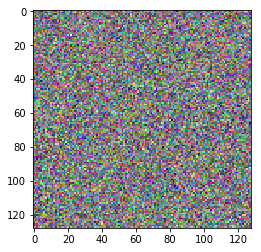

In [94]:
input = (torch.ones(3, 128, 128) * 0.5) + (torch.randn(3, 128, 128) * 0.2) 
#print(input)

array = np.asarray((np.eye(128, dtype=float), np.eye(128, dtype=float), np.eye(128, dtype=float)))
eye = torch.from_numpy(array).float()

print(input.numpy().shape)
print(eye.numpy().shape)
input += eye

input = input.cuda()

plt.imshow(input.cpu().numpy().transpose((1, 2, 0)))

input = Variable(input).cuda()
input = input.unsqueeze(0)


In [123]:
def GetMatchingLayer(inChannels, outChannels, stride=(2,2), padding=(0,0)):
    return nn.Sequential(
            nn.Conv2d(in_channels=inChannels, out_channels=outChannels, kernel_size=(1,1), stride=stride, padding=padding),
            nn.BatchNorm2d(num_features=outChannels)).cuda()

(1, 4, 64, 64)


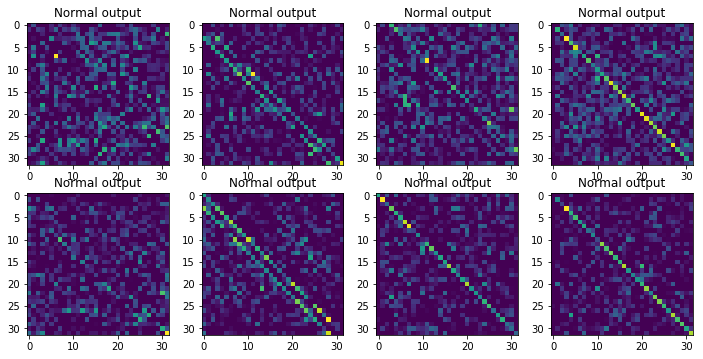

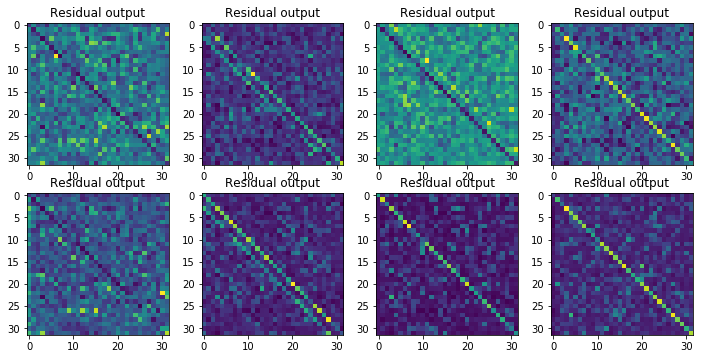

In [130]:
conv01 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3,3), stride=(2,2), padding=(3,3), dilation=(3,3)).cuda()
batn01 = nn.BatchNorm2d(num_features=4).cuda()
relu01 = nn.ReLU().cuda()

conv02 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3,3), stride=(2,2), padding=(3,3), dilation=(3,3)).cuda()
batn02 = nn.BatchNorm2d(num_features=8).cuda()
relu02 = nn.ReLU().cuda()

eluFC = nn.ELU().cuda()

resi01 = GetMatchingLayer(3, 4)(input)
print(resi01.cpu().data.numpy().shape)

out = conv01(input)
out = batn01(out)

out = out + resi01

out = relu01(out)

resi02 = GetMatchingLayer(4, 8)(out)

out = conv02(out)
out = batn02(out)

out = out + resi02

out = relu02(out)

#resi03 = matching3(out)

outnorm = eluFC(out)
outresi = eluFC(out + resi02)

plt.figure(figsize=(12,12))
for i in range(outnorm.data.cpu().numpy().shape[1]):
    plt.subplot(4, 4, i + 1)
    plt.title('Normal output')
    plt.imshow(outnorm.data.cpu().numpy()[0][i])

plt.figure(figsize=(12,12))
for i in range(outresi.data.cpu().numpy().shape[1]):
    plt.subplot(4, 4, i + 1)
    plt.title('Residual output')
    plt.imshow((outresi).data.cpu().numpy()[0][i])

In [102]:
#vgg16 = torchvision.models.vgg16_bn()
#print(vgg16)
net = torchvision.models.alexnet()
print(net)

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)


Processing...
Done!
torch.Size([60000, 28, 28])
torch.Size([60000])


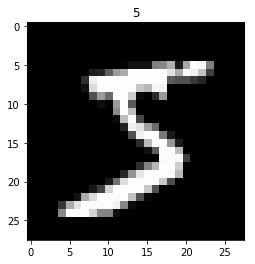

CNN (
  (conv1): Sequential (
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv2): Sequential (
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (out): Linear (1568 -> 10)
)
Epoch:  0 | train loss: 2.3145 | test accuracy: 0.10


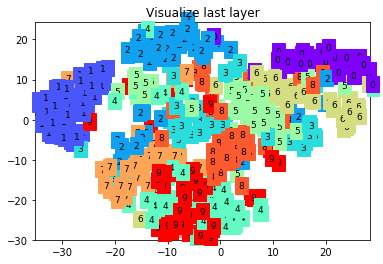

Epoch:  0 | train loss: 0.5546 | test accuracy: 0.83


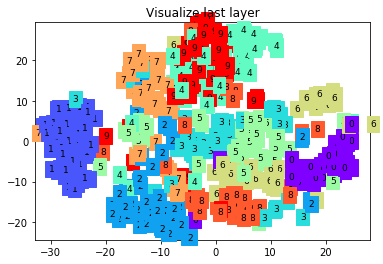

Epoch:  0 | train loss: 0.5857 | test accuracy: 0.89


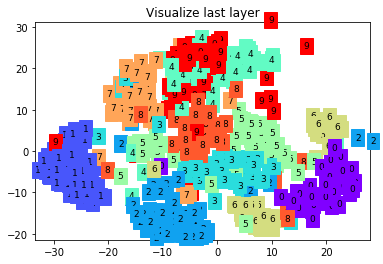

Epoch:  0 | train loss: 0.1876 | test accuracy: 0.92


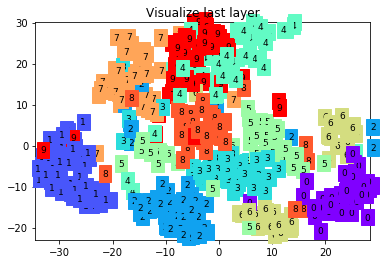

Epoch:  0 | train loss: 0.0601 | test accuracy: 0.94


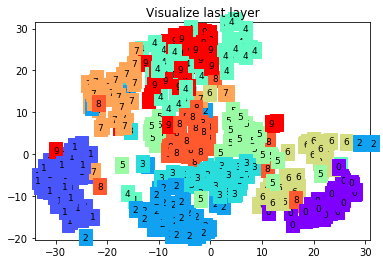

Epoch:  0 | train loss: 0.1762 | test accuracy: 0.95


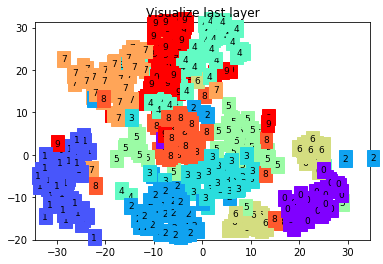

Epoch:  0 | train loss: 0.0992 | test accuracy: 0.94


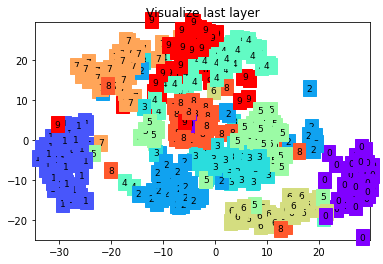

Epoch:  0 | train loss: 0.2193 | test accuracy: 0.95


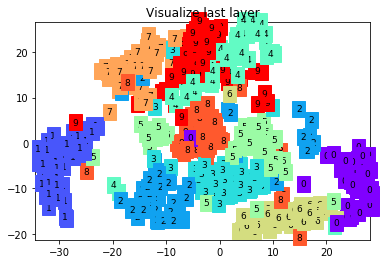

Epoch:  0 | train loss: 0.0377 | test accuracy: 0.96


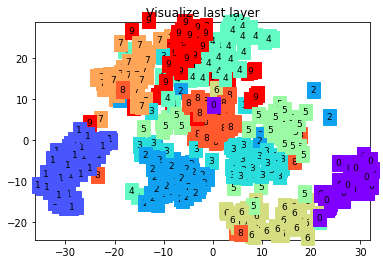

Epoch:  0 | train loss: 0.0537 | test accuracy: 0.96


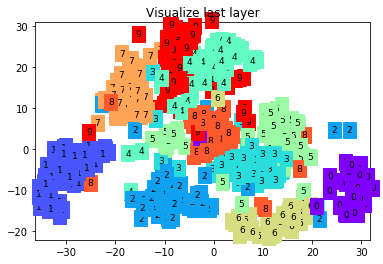

Epoch:  0 | train loss: 0.0267 | test accuracy: 0.96


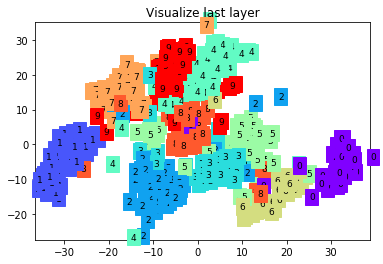

Epoch:  0 | train loss: 0.0907 | test accuracy: 0.96


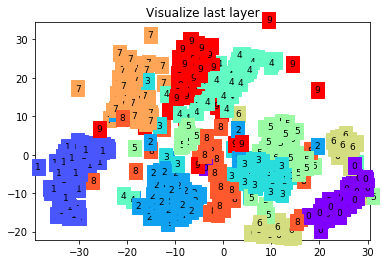

Epoch:  0 | train loss: 0.0974 | test accuracy: 0.97


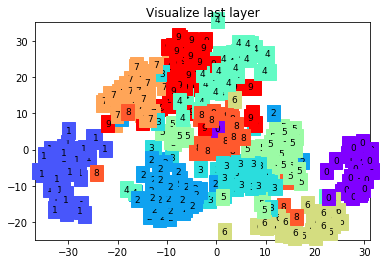

Epoch:  0 | train loss: 0.3146 | test accuracy: 0.97


KeyboardInterrupt: 

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = True   # set to False if you have downloaded


# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# convert test data into Variable, pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1), volatile=True).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization


cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0], '| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
                labels = test_y.numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()

# print 10 predictions from test data
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')